In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. MÔ TẢ BÀI TOÁN
* Quora là một nền tảng để mọi người học hỏi với nhau. Mọi người có thể đăng những câu hỏi và người khác vào chia sẻ, trả lời những thắc mắc đó. Mục đích của bài toán này là để chỉ ra câu hỏi có chân thành hay không. Những câu hỏi không chân thành thường là những câu đưa ra tuyên bố quan điểm của mình hơn là để tìm những câu trả lời có ích: không trung lập, khiêu khích hoặc chê bai, không có căn cứ thực tế và nội dung khiêu dâm.
* Một thách thức lớn đó là loại bỏ đi những câu hỏi toxic - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm câu trả lời hữu ích.
* Vậy mục tiêu, thách thức của dự án này là loại bỏ những câu hỏi "insincere" - những câu hỏi không mang tính chất đóng góp, thiếu chân thành, thậm chí để đả kích một cá nhân, tập thể hay tổ chức nào đó. Ngoài ra, những câu hỏi có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích cũng cần bị loại bỏ.
* Input: Câu hỏi dưới dạng văn bản
* Output: 0/1 (Yes/No)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS
import seaborn as sns
# from nltk import WordNetLemmatizer
import re
import string
import os
import seaborn as sb
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
from sklearn import preprocessing
from tqdm import tqdm

# **2. KHẢO SÁT DỮ LIỆU**
Dữ liệu được cung cấp gồm 2 file chính là train.csv và test.csv.

In [ ]:
train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

In [ ]:
train.head()

In [ ]:
print("Train shape :", train.shape)
print("Test shape :", test.shape)

In [ ]:
train.info()

**Nhận xét:**
Tập dữ liệu train có 1306122 câu hỏi và tập test chứa 375806 câu hỏi để đánh giá hiệu năng mô hình. Trong đó, không có giá trị null nào và có 3 trường dữ liệu: qid, question_text, target.

qid : id của câu hỏi, mỗi câu hỏi có 1 id riêng phân biệt

question_text : nội dung câu hỏi ở dạng text

target: gồm 2 nhãn 0 và 1. Nhãn 0 là sincere là câu hỏi chân thành, nhãn 1 là insincere là câu hỏi không chân thành (toxic)

In [ ]:
print("Tổng số dữ liệu trong tập train: ",train.shape[0])
print("Số câu hỏi bình thường: ", len(train[train.target == 0]))
print("Số câu hỏi toxic: ",len(train[train.target == 1]))
print("Tỉ lệ giữa 2 lớp: ",len(train[train.target == 1])/len(train[train.target == 0]))
print('\n')

sb.countplot(train['target'])

**Nhận xét:**
Số lượng câu hỏi sincerce:insincere có sự chênh lệch rất lớn. Tỉ lệ dữ liệu giữa 2 nhóm là 1:15 .Số lượng câu hỏi chân thành chiếm đến gần 94% tập dữ liệu trong khi số lượng câu hỏi không chân thành chỉ chiếm 6.2%.Sự mất cân bằng nghiêm trọng này sẽ dẫn tới 2 vấn đề lớn:

* Đánh giá sai chất lượng mô hình: sự mất cân bằng có thể khiến thước đo đánh giá mô hình là độ chính xác (accuracy) có thể đạt được rất cao mà không cần tới mô hình. Minh chứng đơn giản với bộ dữ liệu trên thì nếu kết quả dự đoán đưa ra tất cả đều có target = 0 thì độ chính xác đã đạt 94%.
* Mô hình dự đoán kém chính xác: sự mất cân bằng có thể gây hiện tượng Overfitting, khiến kết quả dự đoán ra thường nghiêng về nhóm đa số và kém trên nhóm thiểu số trong khi tầm quan trọng của việc dự báo được chính xác một mẫu thuộc nhóm thiểu số lớn hơn nhiều so với dự báo mẫu thuộc nhóm đa số. ( VD ở đây việc quan trọng nhất là xác định được nhóm câu hỏi toxic)

-> Dữ liệu này mất cân bằng rất lớn

-> Cần áp dụng các phương pháp cân bằng dữ liệu

-> F1-score sẽ được sử dụng để đánh giá hiệu năng của mô hình. F1 score là độ cân bằng đồng đều giữa precision và recall

# **3. CHUẨN BỊ MÔ HÌNH**

Trước khi thực hiện bất cứ quá trình tiền xử lý dữ liệu hay áp dụng các model khác nhau cho bài toán thì ta nghĩ tới việc đưa ra một giải pháp nền tảng để từ đó phát triển và có thể dễ dàng đánh giá độ hiệu quả của các thay đổi sau này. Vì thế, trước tiên, ta sẽ xây dựng một mô hình đơn giản để dự đoán bài toàn trên.

**3.1. TF-IDF** 

Việc đầu tiên cần làm là xử lý dữ liệu đầu vào. Với dữ liệu dạng text, chúng ta cần tiến hành encoding để đưa dữ liệu về dạng không gian vector. Cách đơn giản nhất là sử dụng one-hot encoding. Tuy nhiên, one-hot encoding mang lại ít giá trị thông tin và có độ khái quát yếu. Ta đưa ra một giải pháp tốt hơn 1 chút đó là sử dụng TF-IDF.

những từ có giá trị TF-IDF cao là những từ xuất hiện nhiều trong văn bản này, và xuất hiện ít trong các văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khoá của văn bản đó).

In [ ]:
#sử dụng tf-idf từ thư viện sklearn
tfidf = TfidfVectorizer(ngram_range=(1, 3))

Ở đây ta chỉnh tham số ngram_range=(1,3) để tạo được các cụm từ gồm 1-3 từ trong bộ dữ liệu. Ví dụ với câu "Python is cool" sẽ sinh ra được các từ và cụm từ "Python", "is", "cool", "Python is", "Python is cool" , "is cool". Điều này sẽ giúp ta tạo được mối quan hệ giữa các cụm từ xuất hiện trong tập dữ liệu.


**3.2. LinearSVC**

Thử nghiệm với nhiều tập mẫu cho thấy kết quả thu được từ LinearSVC là cao và ổn định nhất. Vì vậy, ta chọn LinearSVC làm mô hình cơ sở.
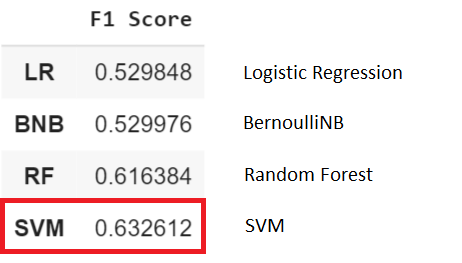

LinearSVC giúp ta tìm được đường phân chia giữa 2 lớp sao cho margin là lớn nhất. Việc margin rộng hơn sẽ mang lại hiệu ứng phân lớp tốt hơn vì sự phân chia giữa hai classes là rạch ròi hơn.
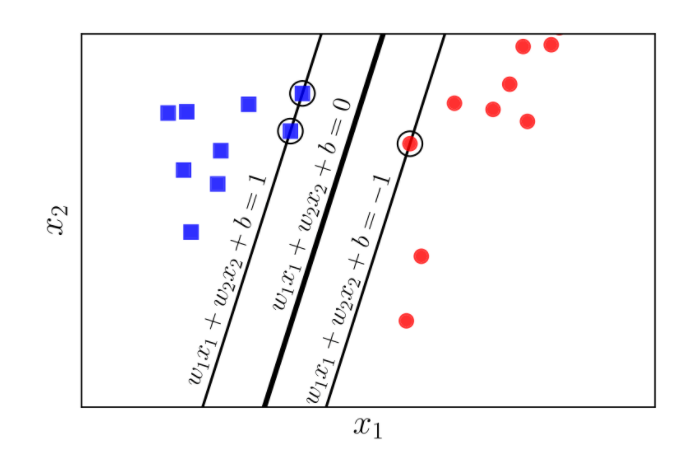

**3.3. Split data to train and validation**

Ta cần chia tập train thành 2 phần để huấn luyện và đánh giá mô hình.

Cách đơn giản nhất là ta có thể lấy ngẫu nhiên một tập dữ liệu con từ tập train để làm tập validation. Tuy nhiên ta để ý tới trường hợp việc lấy ngẫu nhiên từ toàn bộ tập train có thể xảy ra trường hợp ta lấy ra tập validation chứa toàn dữ liệu thuộc cùng một lớp. Vấn đề này đặc biệt dễ xảy ra với tập dữ liệu hiện tại do độ lệch lớn giữa lượng dữ liệu của 2 lớp (tỉ lệ 15:1).

Giải pháp: lấy ngẫu nhiên dữ liệu từ từng lớp. Ví dụ với bộ dữ liệu hiện tại, ta muốn tạo ra tập validation có tỉ lệ 1:10 từ tập train thì ta lấy ta 1/10 dữ liệu từ lớp có target = 0 và 1/10 dữ liệu từ tập target = 1.

Ta sử dụng hàm train_test_split() của sklearn để chia tập theo phương pháp trên.


In [ ]:
def test_funtion_split():
    X = train.question_text
    y = train.target
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Tỉ lệ giữa 2 lớp trong tập train",len(y_train[y_train == 0])/len(y_train[y_train == 1]))
    print("Tỉ lệ giữa 2 lớp trong tập test",len(y_val[y_val == 0])/len(y_val[y_val == 1]))

test_funtion_split()

Thử chia tập validation với hàm train_test_split ta có thể thấy rõ tỉ lệ giữa 2 lớp ở tập train và validation là khá tương đồng với tỉ lệ của tập train lúc ban đầu.

**3.4. Xây dựng mô hình**

In [ ]:
#Hàm dự đoán sử dụng linear
def predict_linearSVC(X_train,y_train,X_test):
    tfidf.fit(X_train)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    return svm.predict(X_test)
 
#Dự đoán trên tập validation
def validate_base_model():
    X = train.question_text
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

In [ ]:
print('F1-Score của base-model trên tập validation: ',validate_base_model())

In [ ]:
def create_file_submission(predict):
    submission = pd.DataFrame(test['qid'])
    submission['prediction'] = predict
    submission.to_csv('submission.csv', index=False)
    
def submit_base_model():
    X_train = train['question_text']
    y_train = train.target
    X_test = test['question_text']
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)

Ta submit thử với base model để kiểm tra điểm số đạt được trên tập test so với tập validation

In [ ]:
# submit_base_model()

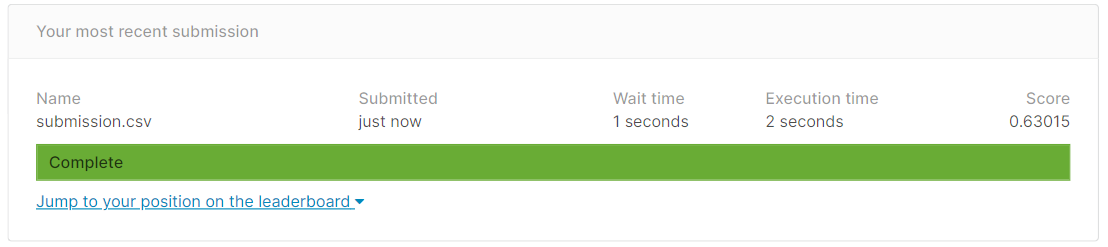

**Nhận xét:**
Điểm số đạt được trên tập test khá tương đồng với điểm số trên tập validation cho thấy tập validation đã đánh giá chính xác hiệu năng của model đồng thời cho thấy mô hình không xảy ra các hiện tượng underfiting, overfiting.


# **4.XỬ LÝ DỮ LIỆU**


In [ ]:
train.question_text.iloc[0]

Đối với dữ liệu dạng text, chi tiết hơn là dạng câu hỏi trong bài toán này, ta thấy rằng có thể có những phần dữ liệu dư thừa - những phần dữ liệu không mang lại giá trị thể hiện nội dung hay phân loại câu như dấu, chữ cái in hoa, chữ số, các kí tự đặc biệt, stopword (những chữ không mang lại giá trị về nội dung như is, are, am,the,..) .

Sau khi đánh giá ta thấy dữ liệu còn khá phức tạp và nhiều nhiễu. Để đơn giản hoá dữ liệu ta có thể thực hiện một số bước sau:

# * **Clean tag**

Đưa các biểu thức toán học về "MATH EQUATION" và đưa đường dẫn web về "URL".



In [ ]:
print("Math:")
a = 0
for i in range(0,len(train)):
    if '[math]' in train.question_text.iloc[i]:
        print(train.question_text.iloc[i])
        a = a + 1
        if a == 5:
            break
            
print()
print("URL:")
a = 0
for i in range(0,len(train)):
    if 'https' in train.question_text.iloc[i]:
        print(train.question_text.iloc[i])
        a = a + 1
        if a == 5:
            break

Ta thấy rằng nhiều câu hỏi có chứa các biểu thức toán học và đường dẫn URL. Các biểu thức và đường dẫn gần như không có ý nghĩa trong việc phân loại câu hỏi và việc để nguyên các đường dẫn và biểu thức toán này trong quá trình encoding với Tfidf sẽ biến thành các trường khác nhau dễ gây ra nhiễu ảnh hưởng tới quá trình huấn luyện và dự đoán.

Ta tiến hành chuyển các biểu thức toán về "MATH EQUATION" và đường dẫn về "URL". Điều này sẽ khiến chúng được mã hóa giống nhau và thể hiện cùng một phân bố trong quá trình huấn luyện mô hình (mô hình sẽ hiểu các từ đó mang cùng ý nghĩa, tính chất)

In [ ]:
# Xứ lý kí tự toán học và link URL

def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

# * Clean punct
Loại bỏ dấu và các kí tự đặc biệt.

Các dấu và kí tự đặc biệt thường có tác dụng phân loại vì thế ta đơn giản xóa bỏ chúng khỏi câu.

In [ ]:
# Loại bỏ kí tự đặc biệt
# Nguồn: https://www.kaggle.com/canming/ensemble-mean-iii-64-36

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
  return x

# * Mispell Dict

Sửa từ viết sai và đưa một số từ về dạng thông dụng.

In [ ]:
def find_unique_words():
    unique_words = {'a'}
    non_unique_words = {'a'}
    for i in tqdm(range(0,len(train))):
        for word in train.question_text.iloc[i].split():
            if word in unique_words:
                non_unique_words.add(word)
            else:
                unique_words.add(word)
    a = pd.DataFrame(unique_words - non_unique_words)
    return a

find_unique_words().head(30)

Ta tìm ra những từ chỉ xuất hiện 1 lần trên toàn tập train và thấy rằng trong đó bao gồm:

* Các từ bị viết sai chính tả.
* Tên gọi của người.
* Tên gọi trong một số lĩnh vực khác nhau như tên con chíp, tên các loại tiền ảo, tên app,....
* Các từ bị dính bởi dấu câu, kí tự đặc biệt (vd: shop?) - vấn đề này sẽ được loại bỏ với hàm clean punct.

Ta tiến hành sửa các từ viết sai chính tả. Đối với các tên gọi trong các lĩnh vực khác nhau, ta đưa chung chúng về một dạng để khi mã hóa chúng sẽ thể hiện cùng một phân bố (ví dụ như tên gpu "1080ti" ta chuyển về "GPU" hay tên một số loại tiền ảo ta chuyển chung về "bitcoin") trong không gian vector (mô hình sẽ hiểu các từ đó mang cùng ý nghĩa, tính chất).

In [ ]:
# Sửa từ viết sai và đưa một số từ về dạng thông dụng.
# Nguồn: https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

# * Contraction Mapping

Đưa các từ viết tắt về dạng bình thường

In [ ]:
# Bỏ viết tắt
# Nguồn: https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

# * Lemmatizer

Đưa từ được chia về dạng bình thường

Cùng một từ trong những câu khác nhau sẽ chia ở các dạng khác nhau (ví dụ go, goes). Ta đưa các từ đó về dạng gốc để quá trình encoding không hiểu sai chúng thành 2 từ khác nhau

In [ ]:
# Đưa từ được chia về dạng bình thường

# lemmatizer = WordNetLemmatizer()
# def lemma_text(x):
#   x = x.split()
#   x = [lemmatizer.lemmatize(word) for word in x]
#   x = ' '.join(x)
#   return x

# * Stopword

Xóa stopword

Trong các câu chứa rất nhiều những từ xuất hiện nhiều nhưng không có giá trị trong phân loại câu, chúng được gọi là stopword. Xóa bỏ stopword giúp cải thiện hiệu năng, giữ lại những từ quan trọng giúp cải thiện hiệu quả phân lớp của mô hình

In [ ]:
# Xóa stopword
stopwords = STOPWORDS  - {'ought', 'whom',"wouldn't", "you'll", "you've"}# bỏ đi một số từ khiến hiệu quả dự đoán giảm


def remove_stopwords(x):
  x = [word for word in x.split() if word not in stopwords]
  x = ' '.join(x)
  return x

Khi tiền hành validate trên bộ dữ liệu được loại bỏ stopword, xảy ra hiện tượng có sự giảm nhẹ của F1-score.

In [ ]:
# Lấy từ stopword đã bỏ trong câu
def UncommonWords(A, B):
  
    count = {'a'}
      
    # insert words of string A to hash
    for word in A.split():
        if word not in B:
            count.add(word)
    # return required list of words
    
    return count

In [ ]:
# Tạo bảng phân tích đánh giá ảnh hưởng stopword
def create_check_stopword_affection():
    train['question_text_cleaned'] = train['question_text'].apply(lambda x: remove_stopwords(x))
    test['question_text_cleaned'] = test['question_text'].apply(lambda x: remove_stopwords(x))
    
    X = train
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    result_predict_to_check_stopword = pd.DataFrame()
    result_predict_to_check_stopword ['predict_with_stopword'] = predict_linearSVC(X_train.question_text,y_train,X_test.question_text)
    result_predict_to_check_stopword ['predict_without_stopword'] = predict_linearSVC(X_train.question_text_cleaned,y_train,X_test.question_text_cleaned)
    
    a = pd.DataFrame(y_test).reset_index(drop=True, inplace=False)
    result_predict_to_check_stopword = pd.concat([result_predict_to_check_stopword,a],axis = 1)
    a = pd.DataFrame(X_test.question_text).reset_index(drop=True, inplace=False)
    result_predict_to_check_stopword = pd.concat([result_predict_to_check_stopword,a],axis = 1)
    a = pd.DataFrame(X_test.question_text_cleaned).reset_index(drop=True, inplace=False)
    result_predict_to_check_stopword = pd.concat([result_predict_to_check_stopword,a],axis = 1)
    
    result_predict_to_check_stopword['check_with_stopword'] = result_predict_to_check_stopword.predict_with_stopword == result_predict_to_check_stopword.target
    result_predict_to_check_stopword['check_without_stopword'] = result_predict_to_check_stopword.predict_without_stopword == result_predict_to_check_stopword.target
    
    result_predict_to_check_stopword.to_csv("check_stopword_affection.csv",index = False)
    
    
create_check_stopword_affection()

In [ ]:
# file check_stopword_affection lưu trong out/kaggle/working sử dụng để đánh giá sự ảnh hưởng của stopword
check_stopword_affection = pd.read_csv("./check_stopword_affection.csv")


# Tập hợp câu lúc đầu đoán sai, sau khi bỏ stopword đoán đúng
eff = check_stopword_affection[(check_stopword_affection.check_with_stopword == False) & (check_stopword_affection.check_without_stopword == True)]
# Tập hợp câu lúc đầu đoán đúng, sau khi bỏ stopword đoán sai
ineff = check_stopword_affection[(check_stopword_affection.check_with_stopword == True) & (check_stopword_affection.check_without_stopword == False)]

# Tập stopword đã bỏ trong những câu đoán sai thành đúng (hiệu quả)
word_effective = {'a'}
for i in range(0,len(eff)):
    word_effective.update(UncommonWords(eff.question_text.iloc[i],eff.question_text_cleaned.iloc[i]))

# Tập stopword đã bỏ trong những câu đoán đúng thành sai (không hiệu quả)    
word_not_effective = {'a'}
for i in range(0,len(ineff)):
    word_not_effective.update(UncommonWords(ineff.question_text.iloc[i],ineff.question_text_cleaned.iloc[i]))
    

print("Sau khi bỏ stopword, số lượng câu hỏi dự đoán đúng giảm:",len(ineff) - len(eff))
print("Số câu hỏi bị ảnh hưởng (thay đổi kết quả) bới stopword: ",len(ineff) + len(eff))
print("Tổng số câu hỏi: ",len(check_stopword_affection))
print("Tổng số câu hỏi lớp 0: ",len(check_stopword_affection[check_stopword_affection.target == 0]))
print("Tổng số câu hỏi lớp 1: ",len(check_stopword_affection[check_stopword_affection.target == 1]))
print("Trong đó:")
print("    - Với câu hỏi có target = 0 : Đúng thêm ",len(eff[eff.target == 0]),", làm sai mất: ",len(ineff[ineff.target == 0]))
print("    - Với câu hỏi có target = 1 : Đúng thêm ",len(eff[eff.target == 1]),", làm sai mất: ",len(ineff[ineff.target == 1]))
print()
print("Những từ stopword không hiệu quả (khi bỏ đi biến câu đúng thành câu sai): ",word_not_effective - word_effective)

Loại bỏ stopword không gây quá nhiều ảnh hưởng tới dự đoán của mô hình (khoảng trên 2%). Sau khi bỏ stopword, số câu đoán đúng giảm 750 câu, tuy nhiên số liệu ở trên giúp ta phân tích kĩ hơn với từng lớp:

* Với câu hỏi target = 1 (lớp thiểu số), số câu hỏi dự đoán đúng tăng khá đáng kể.
* Số câu hỏi được đoán thuộc lớp 1 có xu hương tăng ( hơn 1800 câu so với trước khi bỏ stop word).
* Với lớp 0, lượng đoán đúng tăng 0.48% và lượng đoán sai tăng 1%.
* Với lớp 1, lượng đoán đúng tăng 8.16% và lượng đoán sai tăng 4,7%.
Với dữ liệu độ lệch lớn như hiện tại, dự đoán sẽ có xu hướng lệch về lớp đa số (lớp 0). Số liệu trên cho thấy, lớp 1 có xu hướng và tỉ lệ dự đoán đúng tăng , điều đó chứng tỏ hiệu quả dự đoán lớp thiểu số đang được tăng lên.

Số lượng câu đoán đúng giảm nhưng đó là trên bộ dữ liệu thiếu cân bằng. Với số liệu ở dạng % ta có thể thấy nếu bộ dữ liệu có tỉ lệ ngang nhau giữa 2 lớp, loại bỏ stopword có thể giúp tăng gần 3% số câu trả lời đúng. Đây là con số khả quan chứng tỏ việc loại bỏ stopword là có hiệu quả.

Một số stopword không hiệu quả được lọc ra phía trên để loại bỏ khỏi bộ stopword.

# * Dữ liệu được xử lý

In [ ]:
# Gọi tất cả các hàm tiền xử lý dữ liệu trên
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = clean_contractions(x)
  x = remove_stopwords(x)
#   x = lemma_text(x)
  return x

In [ ]:
#Tạo ra 1 tập dữ liệu đã được cleaning
train['question_text_cleaned'] = train['question_text'].apply(lambda x: data_cleaning(x))
test['question_text_cleaned'] = test['question_text'].apply(lambda x: data_cleaning(x))
display(train.head(),test.head())

In [ ]:
def validate_baseModel_dataCleaded():
    X = train.question_text_cleaned
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

print("F1-Score trên tập dữ liệu đã xử lý: ",validate_baseModel_dataCleaded())

In [ ]:
def submit():
    X_train = train['question_text_cleaned']
    y_train = train.target
    X_test = test['question_text_cleaned']
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)
    
# submit()

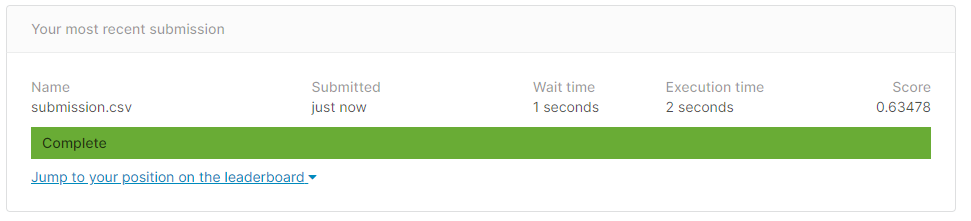

**Nhận xét:**
Điểm số sau khi xử lý dữ liệu đã tăng thêm khoảng 0.4%. Ngoài ra, việc loại bỏ đi stopword và các kí tự thừa cũng khiến thời gian mã hóa dữ liệu từ text sang vector và thời gian huấn luyện mô hình giảm đi đáng kể.


# 5. THUẬT TOÁN

Under sampling là việc ta giảm số lượng các quan sát của nhóm đa số để nó trở nên cân bằng với số quan sát của nhóm thiểu số. Ưu điểm của under sampling là làm cân bằng mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện mà không cần đến thuật toán giả lập mẫu.

**5.1. Simple Under Sampling**

Áp dụng với bộ dữ liệu hiện tại, ta giảm số lượng mẫu của lớp 0 (target = 0) sao cho tỉ lệ giữa 2 lớp là 4:1 bằng cách lấy ngẫu nhiên một số lượng phần tử từ lớp này.


In [ ]:
def validate_undersampling():
    X_target0 = train[train.target == 0].sample(frac = 0.26) #lấy random tập data con từ lớp 0 có kích thước bằng 0.26 lớp 0 ban đầu
    data = X_target0.append(train[train.target == 1])  # ghép với tập data lớp 1
    X = data.question_text_cleaned
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)
    
print("F1-Score với Under Sampling: ",validate_undersampling())

In [ ]:
def submit_undersampling():
    X_target0 = train[train.target == 0].sample(frac = 0.26) #lấy random tập data con từ lớp 0
    data = X_target0.append(train[train.target == 1])  # ghép với tập data lớp 1
    X_train = data.question_text_cleaned
    y_train = data.target
    X_test = test.question_text_cleaned
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)

# submit_undersampling()

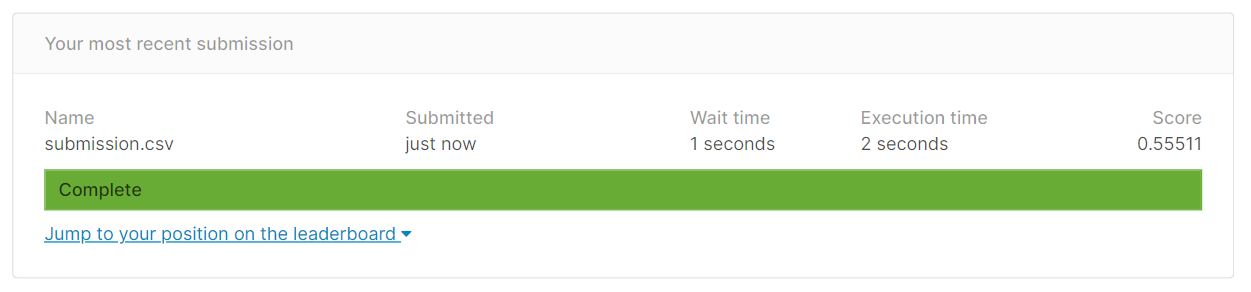

Ta có thể thấy áp dụng under sampling cải thiện tốt khả năng dự đoán trên tập validation nhưng lại làm thụt giảm nghiêm trọng khả năng dự đoán trên tập test.

Điểm số F1_score trên tập validation tăng chủ yếu do so lượng mẫu dùng để đánh giá mô hình trên tập này đã giảm rất nhiều so với ban đầu.

Số lượng mẫu ở tập training bị giảm mạnh (chỉ còn khoảng 1/3 so với lúc đầu) dẫn tới tập dữ liệu trainning không đại diện được cho phân phối của toàn bộ tập dữ liệu dẫn tới hiện tượng overfitting


**5.2. Under Sampling combined K-means**

K-means thuật toán đơn giản nhất của dạng bài toán học có giám sát. K-means dựa vào khoảng cách giữa các vector trong không gian, chia dữ liệu thành các cụm và tìm ra tâm cụm thích hợp.
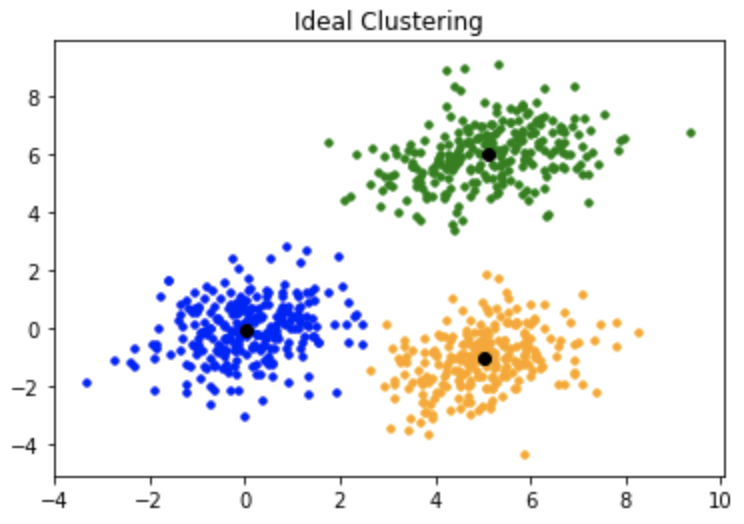

Problem: Vấn đề ta gặp phải khi sử dụng Under Sampling chính là việc cắt giảm số lượng lớn mẫu từ tập 0 khiến tập dữ liệu mới có khả năng không thể hiện được hết phân bố tập dữ liệu ban đầu. Ta biểu diễn đơn giản vấn đề trên trong không gian 2 chiều


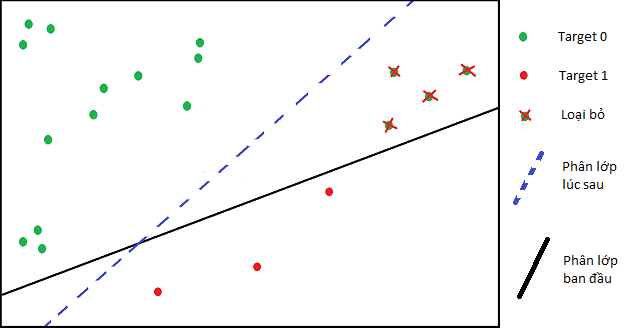

Ta thấy rằng trong trường hợp ta loại bỏ những điểm dữ liệu như trên hình, phân bố dữ liệu tại khu vực đó hoàn toàn bị thay đổi khiến phương trình đường phân lớp tiến sâu vào vùng dữ liệu target 0 và khiến dự đoán bị sai.

Solution: ta sẽ sự dụng K-mean nhằm chia tập câu hỏi đầu vào thành các cụm chứa các câu hỏi có đặc trưng tương đồng (phân bố gần nhau trên tập không gian vector). Sau đó ta tiến hánh loại bớt mẫu ở mỗi cụm. Việc này giúp ta có được tập câu hỏi mới có độ bao quát cao, có thể đại diện cho phân phối toàn tập dữ liệu bạn đầu

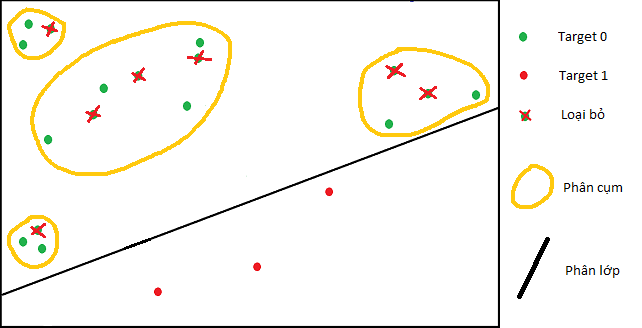

Ta có thể thấy khi phân cụm, những điểm bị xóa đi ở từng cụm sẽ ít gây ra sự thay đổi phân bố trên toàn tập dữ liệu.
Thông thường, khi sử dụng K-mean, ta sẽ sử dụng phương pháp Elbow chọn ra số cluster thích hợp nhất cho tập dữ liệu. Tuy nhiên với bài toán hiện tại, việc tìm ra số cụm thích hợp là không cần thiết. Ta dễ thấy rằng nếu chia ra càng nhiều cụm (tức là chia dữ liệu thành nhiều tập chứa các điểm gần nhau) thì việc xóa bỏ phần tử của mỗi cụm sẽ càng gây ít ảnh hưởng tới phân bố dữ liệu. Vì vậy mục tiêu của ta sẽ là chia ra với số cụm tối đa.

Ví dụ ở bài toán này, tỉ lệ dữ liệu 2 lớp đang là 1:15. Ta muốn giảm dữ liệu lớp 0 xuống sao cho tỉ lệ 2 lớp còn khoảng 1:5, vậy ta sẽ giảm đi 2/3 lượng dữ liệu ở lớp 0. Lớp 0 có 1200000 dữ liệu, ta chia lớp 0 thành 400000 lớp, mỗi lớp sẽ có 3 phần tử và ở mỗi lớp ta sẽ tiến hành xóa 2 phần tử trong đó.

Problem: Vấn đề xảy ra khi sử dụng Kmeans từ thư viện sklearn. Dù đã tối ưu 2 thông số max_iter(số lần lặp tối đa với mỗi lần chạy) và n_init(số lần chạy với mỗi tâm) thì khi tăng số lượng cluster lên đến quá 15 cluster thì xuất hiện tràn ram trên kaggle. Vì vậy ở đây, ta chỉ có thể thử nghiệm với số cluster lớn nhất là 14.

In [ ]:
def remove_data():
    
    train_0 = train[train.target == 0] #lấy ra tập data target 0
    tfidf.fit(train_0.question_text_cleaned) #chuyển text sang vector với tfidf
    encode = tfidf.transform(train_0.question_text_cleaned)
    kmeans = KMeans(n_clusters=14,verbose=1,max_iter=5,n_init=3) # số cluster = 14,khởi tạo lấy tâm ngẫu nhiên 3 lần, mỗi lần tìm tâm tối ưu 5 lần
    kmeans.fit(encode)
    train_0['cluster'] = kmeans.labels_ #tạo cột đánh nhãn tên cụm

    #mỗi cụm lấy ra 1/4 data để
    a = train_0[train_0.cluster==0] 
    data = a.sample(frac = 0.25)
    for i in range(1,14):
        a = train_0[train_0.cluster==i]
        b = a.sample(frac = 0.25)
        data = data.append(b)

    data.drop('cluster',axis='columns',inplace=True)

    data = data.append(train[train.target == 1])#gộp tập lớp 0 sau khi giảm bớt dữ liệu với tập dữ liệu lớp 1
    return data

data_removed =  remove_data()

In [ ]:
def validation_undersampling_kmean():
    X = data_removed.question_text_cleaned
    y = data_removed.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    predict = predict_linearSVC(X_train,y_train,X_test)
    return f1_score(predict,y_test)

print("F1-Score với Under Sampling và K-mean: ",validation_undersampling_kmean())

In [ ]:
def submit_undersampling_kmean():
    X_train = data_removed.question_text_cleaned
    y_train = data_removed.target
    X_test = test.question_text_cleaned
    predict = predict_linearSVC(X_train,y_train,X_test)
    create_file_submission(predict)

# submit_undersampling_kmean()

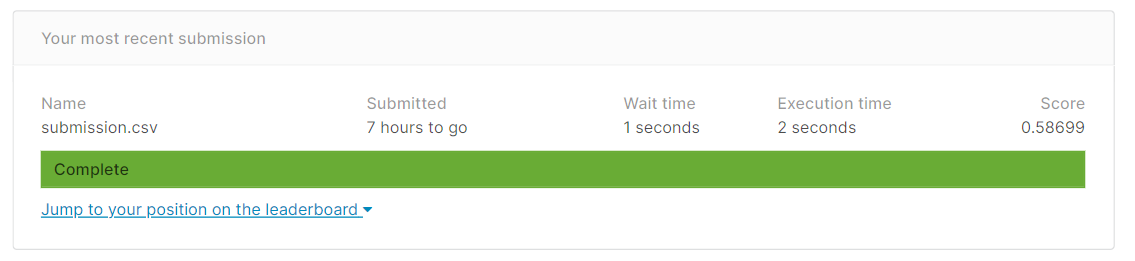

**Nhận xét:**
Có thể thấy rằng mô hình vẫn cho ra kết quả rất cao trên tập validation nhưng lại thấp trên tập test. Tuy nhiên, việc sử dụng K-mean đã tăng F1-Score lên hơn 3% so với lúc trước chứng tỏ việc xóa phần tử ở từng cụm là có hiệu quả và đã cải thiện đáng kể phương pháp Under Sampling. Nếu có thể tăng số cụm lên thì có khả năng hiệu quả của mô hình cũng sẽ được cải thiện.



# 6. CẢI THIỆN

Sinh thêm các trường dữ liệu có thể tăng thông tin từ đó ảnh hưởng tới khả năng dự đoán mô hình. Đối với bài toán hiện tại, một vài đặc điểm về số lượng kí tự đặc biệt, chữ số, số lượng stopword,... trong câu có thể là những thông tin quan trọng giúp phân loại câu hỏi.

Ta thêm 1 số trường thông tin cho câu hỏi:

* freq_id : tần suất xuất hiện của id
* q_len : độ dài của các câu hỏi
* n_words : số từ trong câu hỏi
* numeric_words : số lượng các chữ số trong câu
* sp_char_words : số lượng các kí tự đặc biệt trong câu
* char_words : số lượng các kí tự trong câu
* unique_words : số lượng các từ duy nhất trong câu

In [ ]:
def generate_feature():
    train['qlen'] = train['question_text'].str.len() 
    train['n_words'] = train['question_text'].apply(lambda row: len(row.split(" ")))
    train['numeric_words'] = train['question_text'].apply(lambda row: sum(c.isdigit() for c in row))
    train['sp_char_words'] = train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
    train['char_words'] = train['question_text'].apply(lambda row: len(str(row)))
    train['unique_words'] = train['question_text'].apply(lambda row: len(set(str(row).split())))
    train['stopwords'] = train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
    test['qlen'] = test['question_text'].str.len() 
    test['n_words'] = test['question_text'].apply(lambda row: len(row.split(" ")))
    test['numeric_words'] = test['question_text'].apply(lambda row: sum(c.isdigit() for c in row))
    test['sp_char_words'] = test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
    test['char_words'] = test['question_text'].apply(lambda row: len(str(row)))
    test['unique_words'] = test['question_text'].apply(lambda row: len(set(str(row).split())))
    test['stopwords'] = test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS])-1)
    
generate_feature()
display(train.head(),test.head())

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
 
corr = train.drop(['qid','question_text','question_text_cleaned'],axis='columns').corr() # tính độ tương quan giữa 2 các cặp dữ liệu, càng gần 0 độ tương quan càng thấp

# Draw the heatmap
sns.heatmap(corr, ax=ax)

plt.title("Correlation matrix")
plt.show()

Từ biểu đồ mức độ tương quan giữa các trường cho ta thấy rằng nếu xét độc lập thì các trường có độ tương quan khá thấp với target (khoảng 0.1). Tuy nhiên cũng có thể target bị ảnh hưởng bởi nhiều trường. Ta tiến hành thử nghiệm với các trường.

In [ ]:
def validate_with_new_feature():
    X = train[['question_text_cleaned','qlen','n_words','numeric_words','sp_char_words','char_words','unique_words','stopwords']]
    y = train.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    tfidf.fit(X_train.question_text_cleaned)

    A_train = tfidf.transform(X_train.question_text_cleaned)
    A_test = tfidf.transform(X_test.question_text_cleaned)

    scaler = preprocessing.MinMaxScaler()
    print(scaler)
    scaled_train = scaler.fit_transform(X_train[['qlen','n_words','numeric_words','sp_char_words','unique_words','stopwords']])
    scaled_test = scaler.fit_transform(X_test[['qlen','n_words','numeric_words','sp_char_words','unique_words','stopwords']])

    X_train = hstack([A_train,coo_matrix(scaled_train)])
    X_test = hstack([A_test,coo_matrix(scaled_test)])
    svm = LinearSVC()
    svm.fit(X_train,y_train)
    return f1_score(svm.predict(X_test),y_test)

print("F1-Score với new Feature: ",validate_with_new_feature())

In [ ]:
def submit_with_new_feature():

    tfidf.fit(train.question_text_cleaned)

    A_train = tfidf.transform(train.question_text_cleaned)
    A_test = tfidf.transform(test.question_text_cleaned)

    scaler = preprocessing.MinMaxScaler()
    print(scaler)
    scaled_train = scaler.fit_transform(train[['qlen','n_words','numeric_words','sp_char_words','unique_words','stopwords']])
    scaled_test = scaler.fit_transform(test[['qlen','n_words','numeric_words','sp_char_words','unique_words','stopwords']])

    X_train = hstack([A_train,coo_matrix(scaled_train)])
    X_test = hstack([A_test,coo_matrix(scaled_test)])
    svm = LinearSVC()
    svm.fit(X_train,train.target)
    predict = svm.predict(X_test)

    create_file_submission(predict)
    
submit_with_new_feature()

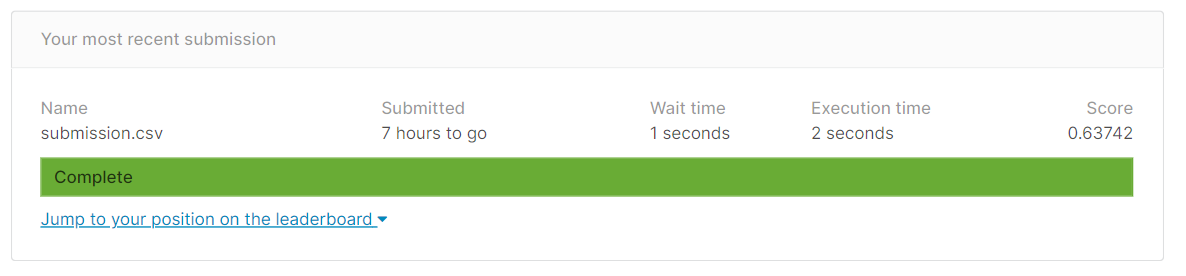

**Nhận xét:**
Điểm số đã được cải thiện hơn so với trước. Tập feature mới được thêm vào đã có hiệu quả.



# 7. KẾT QUẢ

Ưu điểm:
* Đã cải thiện được F1-score mô hình cơ sở từ 0.6305 lên 0.6375
* Với bài toán hiện tại, khi so sánh với những mô hình deep learning, Linear SVC cũng cho thấy khả năng phân lớp tương đối hiệu quả.
* Mô hình được cải thiện nhẹ với tập dữ liệu sau khi được lọc bớt phần thừa và tăng thêm trường dữ liệu.
* K-mean có thể được áp dụng để cải thiện cho phương pháp Under Sampling, tránh hiện tượng Overfitting.

Nhược điểm:
* Mã hóa text bằng Tfidf là tương đối đơn giản, vector được tạo ra mang ít giá trị trong huấn luyện mô hình.
* K-mean được sử dụng hiệu quả nhưng số lượng cluster khá thấp, không đủ để cải thiện mô hình với Under Sampling.

Hướng tiếp cận cải thiện mô hình:
* Sử dụng các bộ vector biểu diễn từ được pretrain như glove thay thế Tfidf, các vector này tận dụng thông tin về mối quan hệ ngữ nghĩa giữa các từ tốt hơn, mang lại nhiều thông tin hơn trong quá trình huấn luyện mô hình.
* Sử dụng phương pháp Over Sampling tăng thêm dữ liệu cho tập thiểu số.
* Áp dụng một số mô hình deep learning như LSTM, RNN.